### Intracellular Ca signalling model

1. Markov state model was built based on "Allosteric Regulation of the P2X4 Recepter Channel Pore Dilation" by Zemkova, Khadra, Rokic, Tvrdonova, Sherman, and Stojikovic.

- This is the 13-state model

2. The relative contribution of Ca to total inward current in the cell (HEK293) was reported to be 8.24 +- 0.36% by Garcia-Guzman. -> This may need to be adjusted for rat P2X4 channel
3. The diameter of HEK293 cell body is approximated to be 13 microns -> r = 6.5 microns
4. The diameter of microglia cell body is approximated to be 5.2 microns -> r = 2.6 microns (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4213482/)
5. Beyond the buffering effects of calmodulin was handled by Rachel
6. The intermediate product of this code is "intracellular Ca transient"
7. The final outcome of this code is "TNF-alpha transient"

*1. Markov state model was built based on "Dual gating mechanism and function of P2X7 receptor channels" by Khadra and modified to adjust the current profile from the activation by BzATP to ATP. 

- This is the 12-state model
- BzATP = 4.11863563exp(ATP*0.00479906) 

#### Limitations & Assumptions

1. NFAT terms with no detail connection to buffering effects.

2. No TNF terms

#### NFATNn Profile & TNF-alpha release

1. Even after adjusting some of parameters, there is no supporting data to explain or indicating the scale of concentrations. 
2. The pattern of profile will be used as a switch of TNF-alpha release and the concentration of NFATNn will not influence on the degree of release
3. The release of TNF-alpha will be fully assumed based on general RNA transcription and translation. https://www.mathworks.com/help/simbio/gs/-model-a-gene-regulation-pathway.html?requestedDomain=true

In [1]:
# Function for integreating ODE and displaying results
import scipy.integrate
from scipy.integrate import odeint
import numpy as np
import matplotlib.pylab as plt
import math
from math import exp
from scipy.interpolate import spline
%matplotlib inline

# Importing the microglia related packages
import data_v2 as dt      # Data sorting code
import TNFa as ta      # TNFa release code
import NFAT as nt      # NFAT cycle code
import MSMp2x4 as p4   # Markov State Model for P2X4 channel
import MSMp2x7 as p7   # Markov State Model for P2X7 channel
import SBbuffers as bf # Buffers (Fura-2, Calmodulin, and Calsequestrin) code
import SERCAER as er   # SERCA Pump code
import NCX as nx       # Na/Ca exchanger code
import calculator_v2 as ca

import numpy.random as npr
# normal random distribution
from numpy.random import normal as nprn
# uniform random distribution
from numpy.random import uniform as npru


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/bensapple/Dropbox/Postdoctoral2017-/Modeling-Codes/Microglia/compartments/SERCAER.py:30: RuntimeWarning: invalid value encountered in double_scalars
  JERtoCyt = QERCa*VmaxSERCA*(((Cai/Kmf)**H)-((CaER/Kmr)**H))/(1+((Cai/Kmf)**H)+((CaER/Kmr)**H))
/Users/bensapple/Dropbox/Postdoctoral2017-/Modeling-Codes/Microglia/compartments/NFAT.py:47: RuntimeWarning: invalid value encountered in double_scalars
  actN = (Cai**n)/((Cai**n)+((KmN**n)*(1+Kd1/CaM)))
/Users/bensapple/Dropbox/Postdoctoral2017-/Modeling-Codes/Microglia/compartments/TNFa.py:56: RuntimeWarning: invalid value encountered in double_scalars
  Rexo = kmaxexo/(1+(IC50NFAT2/NFATNn)**nNFAT2)*TNFa + (kmaxleak/(1+(IC50Caleak/Cai)**nCaleak))*TNFa
/Use

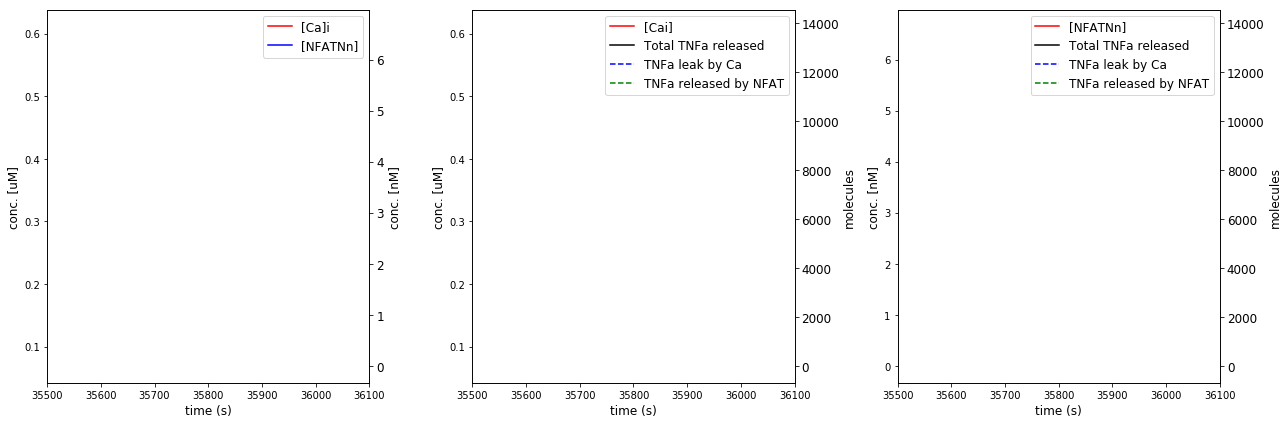

In [10]:
ca.plots(ca.total(480,20,10,4000,1000),18,6,35500,36100) # total(st,Du,step,interval,ATP)

/Users/bensapple/Dropbox/Postdoctoral2017-/Modeling-Codes/Microglia/compartments/SERCAER.py:30: RuntimeWarning: invalid value encountered in double_scalars
  JERtoCyt = QERCa*VmaxSERCA*(((Cai/Kmf)**H)-((CaER/Kmr)**H))/(1+((Cai/Kmf)**H)+((CaER/Kmr)**H))


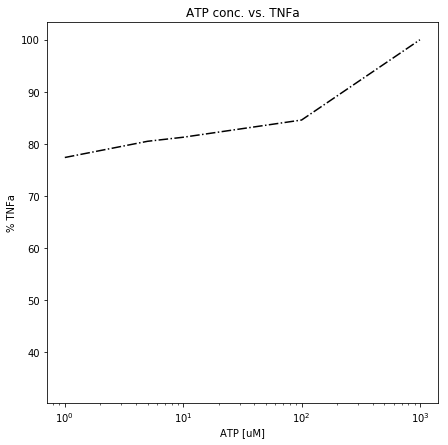

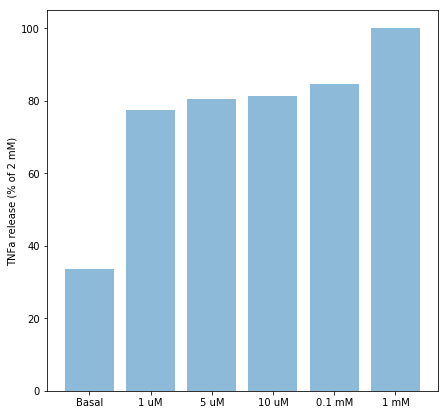

In [5]:
def ATPvsTNF():
    ATPrange = [0,1,5,10,100,1000] # [uM]
    eTNFa = [] # released TNFa at steady state in [molecule]
    rTNFa = [] # released TNFa at steady state percent
    for A in ATPrange:
        dummy = []
        results = ca.total(480,20,10,2000,A)
        Cai, CaM, CaF, CaS, CaER, p4D1, p4D2, p4D3, p4D4, p4C1, p4C2, p4C3, p4C4, p4Q1, p4Q2, p4Q3, p4Q4, p4N, p7D1, p7D2, p7D3, p7D4, p7C1, p7C2, p7C3, p7C4, p7Q1, p7Q2, p7Q3, p7Q4, NFATpc, NFATpn, NFATNc, NFATNn, DNA, DNA_TNF, mRNA, TNFa, TNFa_leak, TNFa_release, TNFa_release_total, time = results
        iters = np.arange(np.shape(time)[0])
        for i in iters:
            if time[i] >= 30000 and time[i] < 40000:
                dummy = np.append(dummy,TNFa_release_total[i])
        dummy2 = max(dummy)
        eTNFa = np.append(eTNFa,dummy2)
        dummy = None
        dummy2 = None
    
    TNFaMax = max(eTNFa)
    for T in eTNFa:
        rTNFa = np.append(rTNFa,(T/TNFaMax)*100)
    
    plt.figure(figsize=(7,7))
    plt.semilogx(ATPrange, rTNFa, 'k-.')
    plt.xlabel("ATP [uM]")
    plt.ylabel("% TNFa")
    plt.title('ATP conc. vs. TNFa')
    #plt.grid(True)
    
    #plt.figure(figsize=(7,7))
    #objects = ('1 uM', '5 uM', '7.5 uM', '10 uM', '0.1 mM', '0.2 mM', '1 mM')
    #y_pos = np.arange(len(objects))
    #plt.bar(y_pos, rTNFa, align='center', alpha=0.5)
    #plt.xticks(y_pos, objects)
    #plt.ylabel('TNFa release (% of 1 mM)')
    
    
    return eTNFa

rTNFa = []
eTNFa = ATPvsTNF()
TNFaMax = max(eTNFa)

for T in eTNFa:
    rTNFa = np.append(rTNFa,(T/TNFaMax)*100)

plt.figure(figsize=(7,7))
objects = ('Basal','1 uM', '5 uM', '10 uM', '0.1 mM', '1 mM')
y_pos = np.arange(len(objects))
plt.bar(y_pos, rTNFa, align='center', alpha=0.5)
#plt.ylim(50,105)
plt.xticks(y_pos, objects)
plt.ylabel('TNFa release (% of 2 mM)')


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/bensapple/Dropbox/Postdoctoral2017-/Modeling-Codes/Microglia/compartments/SERCAER.py:30: RuntimeWarning: invalid value encountered in double_scalars
  JERtoCyt = QERCa*VmaxSERCA*(((Cai/Kmf)**H)-((CaER/Kmr)**H))/(1+((Cai/Kmf)**H)+((CaER/Kmr)**H))
/Users/bensapple/Dropbox/Postdoctoral2017-/Modeling-Codes/Microglia/compartments/NFAT.py:47: RuntimeWarning: invalid value encountered in double_scalars
  actN = (Cai**n)/((Cai**n)+((KmN**n)*(1+Kd1/CaM)))
/Users/bensapple/Dropbox/Postdoctoral2017-/Modeling-Codes/Microglia/compartments/TNFa.py:56: RuntimeWarning: invalid value encountered in double_scalars
  Rexo = kmaxexo/(1+(IC50NFAT2/NFATNn)**nNFAT2)*TNFa + (kmaxleak/(1+(IC50Caleak/Cai)**nCaleak))*TNFa
/Use

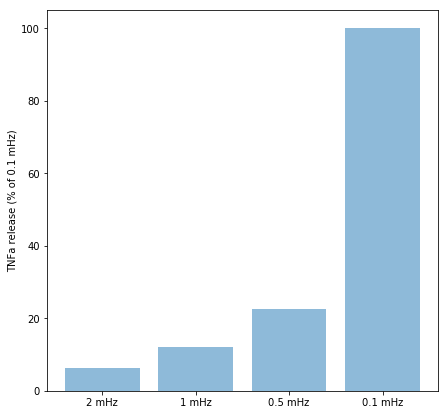

In [11]:
def FreqvsTNF():
    Freq = [500,1000,2000,10000] # Seconds per one cycle
    eTNFa = [] # released TNFa at steady state in [molecule]
    rTNFa = [] # released TNFa at steady state percent
    for F in Freq:
        dummy = []
        results = ca.total(480,20,10,F,1000)
        Cai, CaM, CaF, CaS, CaER, p4D1, p4D2, p4D3, p4D4, p4C1, p4C2, p4C3, p4C4, p4Q1, p4Q2, p4Q3, p4Q4, p4N, p7D1, p7D2, p7D3, p7D4, p7C1, p7C2, p7C3, p7C4, p7Q1, p7Q2, p7Q3, p7Q4, NFATpc, NFATpn, NFATNc, NFATNn, DNA, DNA_TNF, mRNA, TNFa, TNFa_leak, TNFa_release, TNFa_release_total, time = results
        iters = np.arange(np.shape(time)[0])
        for i in iters:
            if time[i] >= F*17 and time[i] < F*20:
                dummy = np.append(dummy,TNFa_release_total[i])
        dummy2 = max(dummy)
        eTNFa = np.append(eTNFa,dummy2)
        dummy = None
        dummy2 = None
    
    return eTNFa

rTNFa = []
eTNFa = FreqvsTNF()
TNFaMax = max(eTNFa)

for T in eTNFa:
    rTNFa = np.append(rTNFa,(T/TNFaMax)*100)

plt.figure(figsize=(7,7))
objects = ('2 mHz', '1 mHz', '0.5 mHz','0.1 mHz')
y_pos = np.arange(len(objects))
plt.bar(y_pos, rTNFa, align='center', alpha=0.5)
#plt.ylim(50,105)
plt.xticks(y_pos, objects)
plt.ylabel('TNFa release (% of 0.1 mHz)')